<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/2b_IslandElectricityMissingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


- Identify and handle missing data from Eirgrid Electricity 15-min reports.
- Check how often Wind electrity production reaches 70% of total production  ("surplus" case when wind electricity is likely to be "curtailed" ) 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import io
import requests


from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from datetime import tzinfo, timedelta, datetime, date

# Any results you write to the current directory are saved as output.

import plotly.express as px
import seaborn as sns

In [ ]:
import os
os.chdir('/content/drive/MyDrive/CA683Project')


# Load aggregated data from Eirgrid

In [ ]:
fileP = 'IslandElectricityOnly2017_2020v3.csv'
newdf = pd.read_csv(fileP, parse_dates=[1])

newdf["hour"] = 0
newdf["isweekday"] = False
newdf["month"] = 0
newdf["year"] = 0

def settimeatt(row):
    row["hour"] = row.date.hour
    row["isweekday"] = (row.date.isoweekday() < 6) 
    row["month"] = row.date.month
    row["year"] = row.date.year
    return row
newdf = newdf.apply(settimeatt, axis='columns')
  
newdf.head()

,Unnamed: 0,date,Year,Month,DayTime,REGION,ActualDemandMW,FORECAST DEMAND(MW),ForecastWndMW,ActualWindMW,ActualGenerationMW,hour,isweekday,month,NetTotal_MW,EWIC_MW,MOYLE_MW,year
0,0,2017-01-01 00:00:00,2017,Jan,"01, 00:00",All Island,3696.0,NaN,1172.0,1214.0,4126.0,0,False,1,-448.0,-170.0,-278.0,2017
1,1,2017-01-01 00:15:00,2017,Jan,"01, 00:15",All Island,3661.0,NaN,1198.0,1168.0,4184.0,0,False,1,-541.0,-244.0,-297.0,2017
2,2,2017-01-01 00:30:00,2017,Jan,"01, 00:30",All Island,3622.0,NaN,1224.0,1131.0,4187.0,0,False,1,-583.0,-286.0,-297.0,2017
3,3,2017-01-01 00:45:00,2017,Jan,"01, 00:45",All Island,3492.0,NaN,1250.0,1025.0,4059.0,0,False,1,-585.0,-287.0,-298.0,2017
4,4,2017-01-01 01:00:00,2017,Jan,"01, 01:00",All Island,3457.0,NaN,1280.0,1123.0,4094.0,1,False,1,-584.0,-287.0,-297.0,2017


In [ ]:
newdf.shape

(145936, 18)

In [ ]:
newdf.describe()

,Unnamed: 0,Year,ActualDemandMW,FORECAST DEMAND(MW),ForecastWndMW,ActualWindMW,ActualGenerationMW,hour,month,NetTotal_MW,EWIC_MW,MOYLE_MW,year
count,145936.00000,145936.000000,145870.000000,0.0,145920.000000,145870.000000,145870.000000,145936.000000,145936.000000,145870.000000,145868.000000,145870.000000,145936.000000
mean,72967.50000,2018.598016,4202.585453,NaN,1362.850267,1335.732961,4254.369630,11.498849,6.327376,-21.878714,-68.418515,46.538863,2018.598016
std,42128.23878,1.197964,847.478204,NaN,1067.786887,971.764030,735.289681,6.922704,3.520318,514.589578,305.980600,245.588651,1.197964
min,0.00000,2017.000000,2396.000000,NaN,10.000000,-59.000000,1925.000000,0.000000,1.000000,-908.000000,-501.000000,-408.000000,2017.000000
25%,36483.75000,2018.000000,3477.000000,NaN,461.000000,483.000000,3766.000000,5.000000,3.000000,-490.000000,-332.000000,-150.000000,2018.000000
50%,72967.50000,2019.000000,4259.000000,NaN,1102.000000,1152.000000,4191.000000,11.000000,6.000000,-80.000000,0.000000,-15.000000,2019.000000
75%,109451.25000,2020.000000,4816.750000,NaN,2052.000000,2077.000000,4704.000000,17.000000,9.000000,366.000000,80.000000,257.000000,2020.000000
max,145935.00000,2021.000000,6904.000000,NaN,4980.000000,4471.000000,7501.000000,23.000000,12.000000,981.000000,579.000000,451.000000,2021.000000


In [ ]:
attributes = ['ActualWindMW', 'ActualGenerationMW', 'ActualDemandMW', 'NetTotal_MW']

In [ ]:
print('-----------Listing all the columns, their names, count of null/not null and type -------------')
print('-----------Checking completness of the data, their types and naming convention -------------')
print(newdf.info())

-----------Listing all the columns, their names, count of null/not null and type -------------
-----------Checking completness of the data, their types and naming convention -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145936 entries, 0 to 145935
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            145936 non-null  int64         
 1   date                  145936 non-null  datetime64[ns]
 2   Year                  145936 non-null  int64         
 3   Month                 145936 non-null  object        
 4   DayTime               145936 non-null  object        
 5    REGION               145936 non-null  object        
 6   ActualDemandMW        145870 non-null  float64       
 7    FORECAST DEMAND(MW)  0 non-null       float64       
 8   ForecastWndMW         145920 non-null  float64       
 9   ActualWindMW          145870 non-null  float64 

In [ ]:
newdf['ActualGenerationMW'].isnull().sum()

66

In [ ]:
newdf.loc[newdf['ActualGenerationMW'].isnull() == True].tail(40)

,Unnamed: 0,date,Year,Month,DayTime,REGION,ActualDemandMW,FORECAST DEMAND(MW),ForecastWndMW,ActualWindMW,ActualGenerationMW,hour,isweekday,month,NetTotal_MW,EWIC_MW,MOYLE_MW,year
16634,16634,2017-06-23 06:30:00,2017,Jun,"23, 06:30",All Island,NaN,NaN,1940.0,NaN,NaN,6,True,6,NaN,NaN,NaN,2017
16635,16635,2017-06-23 06:45:00,2017,Jun,"23, 06:45",All Island,NaN,NaN,1906.0,NaN,NaN,6,True,6,NaN,NaN,NaN,2017
16636,16636,2017-06-23 07:00:00,2017,Jun,"23, 07:00",All Island,NaN,NaN,1821.0,NaN,NaN,7,True,6,NaN,NaN,NaN,2017
16637,16637,2017-06-23 07:15:00,2017,Jun,"23, 07:15",All Island,NaN,NaN,1779.0,NaN,NaN,7,True,6,NaN,NaN,NaN,2017
16638,16638,2017-06-23 07:30:00,2017,Jun,"23, 07:30",All Island,NaN,NaN,1738.0,NaN,NaN,7,True,6,NaN,NaN,NaN,2017
16639,16639,2017-06-23 07:45:00,2017,Jun,"23, 07:45",All Island,NaN,NaN,1696.0,NaN,NaN,7,True,6,NaN,NaN,NaN,2017
16640,16640,2017-06-23 08:00:00,2017,Jun,"23, 08:00",All Island,NaN,NaN,1653.0,NaN,NaN,8,True,6,NaN,NaN,NaN,2017
16641,16641,2017-06-23 08:15:00,2017,Jun,"23, 08:15",All Island,NaN,NaN,1607.0,NaN,NaN,8,True,6,NaN,NaN,NaN,2017
16642,16642,2017-06-23 08:30:00,2017,Jun,"23, 08:30",All Island,NaN,NaN,1561.0,NaN,NaN,8,True,6,NaN,NaN,NaN,2017
16643,16643,2017-06-23 08:45:00,2017,Jun,"23, 08:45",All Island,NaN,NaN,1516.0,NaN,NaN,8,True,6,NaN,NaN,NaN,2017


# Handle Missing data 

## Lots missing until 2017-06-23	2017 -
only start 2017-07-01	2017

In [ ]:
minDate = "2017-07-01 00:00:00"

newdf = newdf.loc[newdf['date'] > minDate]

In [ ]:
newdf['ActualGenerationMW'].isnull().sum()

16

In [ ]:
newdf.loc[newdf['ActualGenerationMW'].isnull() == True]

,Unnamed: 0,date,Year,Month,DayTime,REGION,ActualDemandMW,FORECAST DEMAND(MW),ForecastWndMW,ActualWindMW,ActualGenerationMW,hour,isweekday,month,NetTotal_MW,EWIC_MW,MOYLE_MW,year
26641,26641,2017-10-05 12:15:00,2017,Oct,"05, 12:15",All Island,NaN,NaN,1078.0,NaN,NaN,12,True,10,NaN,NaN,NaN,2017
43016,43016,2018-03-25 01:00:00,2018,Mar,"25, 01:00",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2018
43017,43017,2018-03-25 01:15:00,2018,Mar,"25, 01:15",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2018
43018,43018,2018-03-25 01:30:00,2018,Mar,"25, 01:30",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2018
43019,43019,2018-03-25 01:45:00,2018,Mar,"25, 01:45",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2018
62941,62941,2018-10-18 14:15:00,2018,Oct,"18, 14:15",All Island,NaN,NaN,242.0,NaN,NaN,14,True,10,NaN,NaN,NaN,2018
78636,78636,2019-03-31 01:00:00,2019,Mar,"31, 01:00",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2019
78637,78637,2019-03-31 01:15:00,2019,Mar,"31, 01:15",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2019
78638,78638,2019-03-31 01:30:00,2019,Mar,"31, 01:30",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2019
78639,78639,2019-03-31 01:45:00,2019,Mar,"31, 01:45",All Island,NaN,NaN,NaN,NaN,NaN,1,False,3,NaN,NaN,NaN,2019


## Backfill those few timeslots (max 5 continous slots)

In [ ]:
# Backfill those few timeslots (max 5 continous slots)
for att in attributes:
  newdf[att].fillna(method='ffill', inplace=True, limit=5)



In [ ]:
newdf['ActualGenerationMW'].isnull().sum()

0

# Raw Metrics EDA

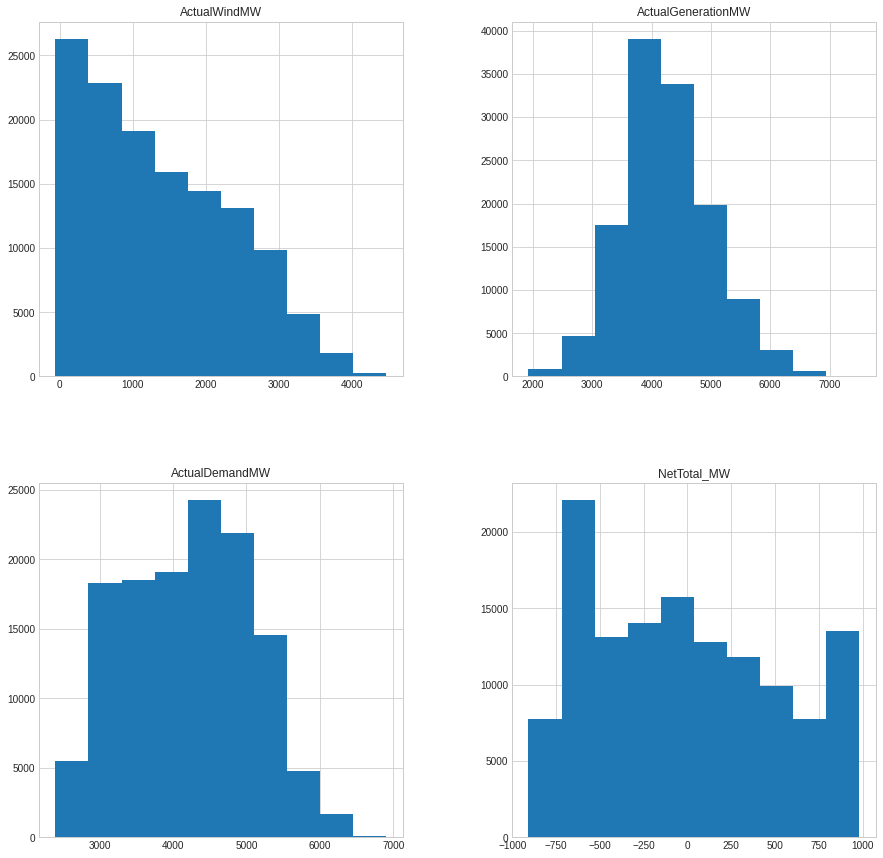

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()

newdf[attributes].hist(ax=ax)
plt.show()

In [ ]:
temporal_att = ['hour', 'month', 'year']


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

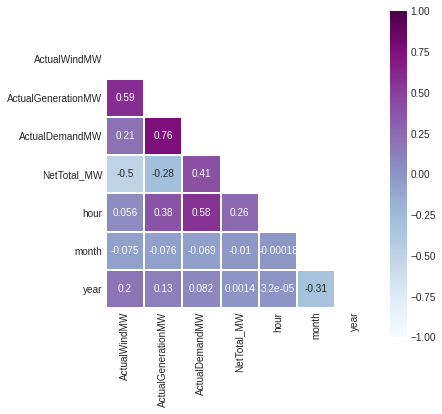

In [ ]:


newdf_corr = newdf.loc[:, (attributes + temporal_att)].corr()

# Then I am generating a mask for the upper triangle
mask = np.triu(np.ones_like(newdf_corr, dtype=bool))
plt.figure(figsize=[6, 6])

# and finally I am plotting the interavtive triangle with the correlation coefficients
sns.heatmap(data=newdf_corr, mask=mask, vmin=-1, vmax=1, cmap='BuPu', annot=True, square=True, linewidths=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [ ]:
newdf['WindMWPercent'] = newdf['ActualWindMW'] / newdf['ActualDemandMW'] * 100



In [ ]:
attributes = attributes + ['WindMWPercent'] 

In [ ]:
fig = make_subplots(
    rows=len(attributes), cols=1,
    subplot_titles=(attributes ))
i =1 

fig.print_grid 
for col in attributes:
  recentdf = newdf.loc[newdf['date'] > "2021-01-01 00:00:00" ]
  #fig = px.scatter(missingAW, x='date', y='hour')
  fig.add_trace(go.Scatter(x=recentdf.date, y=recentdf[col], name=(col),  hovertext='label'), i, 1, secondary_y=False)
  #fig.add_hline(y=eirgridCols[col]].mean()) 
  i = i+1

fig.update_layout(height=800, width=1400)
fig.show()

In [ ]:
def plotOutliers(df, cols):
  fig = plt.figure(figsize=(20, 40))

  # loop over all vars (total: 14)
  for i in range(0, (len(cols))):
    plt.subplot(14, 1, (i+1))
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.axes.set_title(cols[i] )

    x=np.array(df.index.tolist())
    y1=np.array(df[cols[i]])

    plt.plot(x, y1)
    plt.axhline(y=df[cols[i]].mean())
    plt.axhline(y=df[cols[i]].mean()+3*df[cols[i]].std(),color='r')
    plt.axhline(y=df[cols[i]].mean()-3*df[cols[i]].std(),color='r')

    plt.axhline(y=df[cols[i]].mean()+ df[cols[i]].std(),color='y')
    plt.axhline(y=df[cols[i]].mean()- df[cols[i]].std(),color='y')

    plt.title((cols[i] + " Mean: " + str(np.round(df[cols[i]].mean(), 1)) + " Std: " + str(np.round(df[cols[i]].std(), 1))), fontsize=12)

  plt.tight_layout()

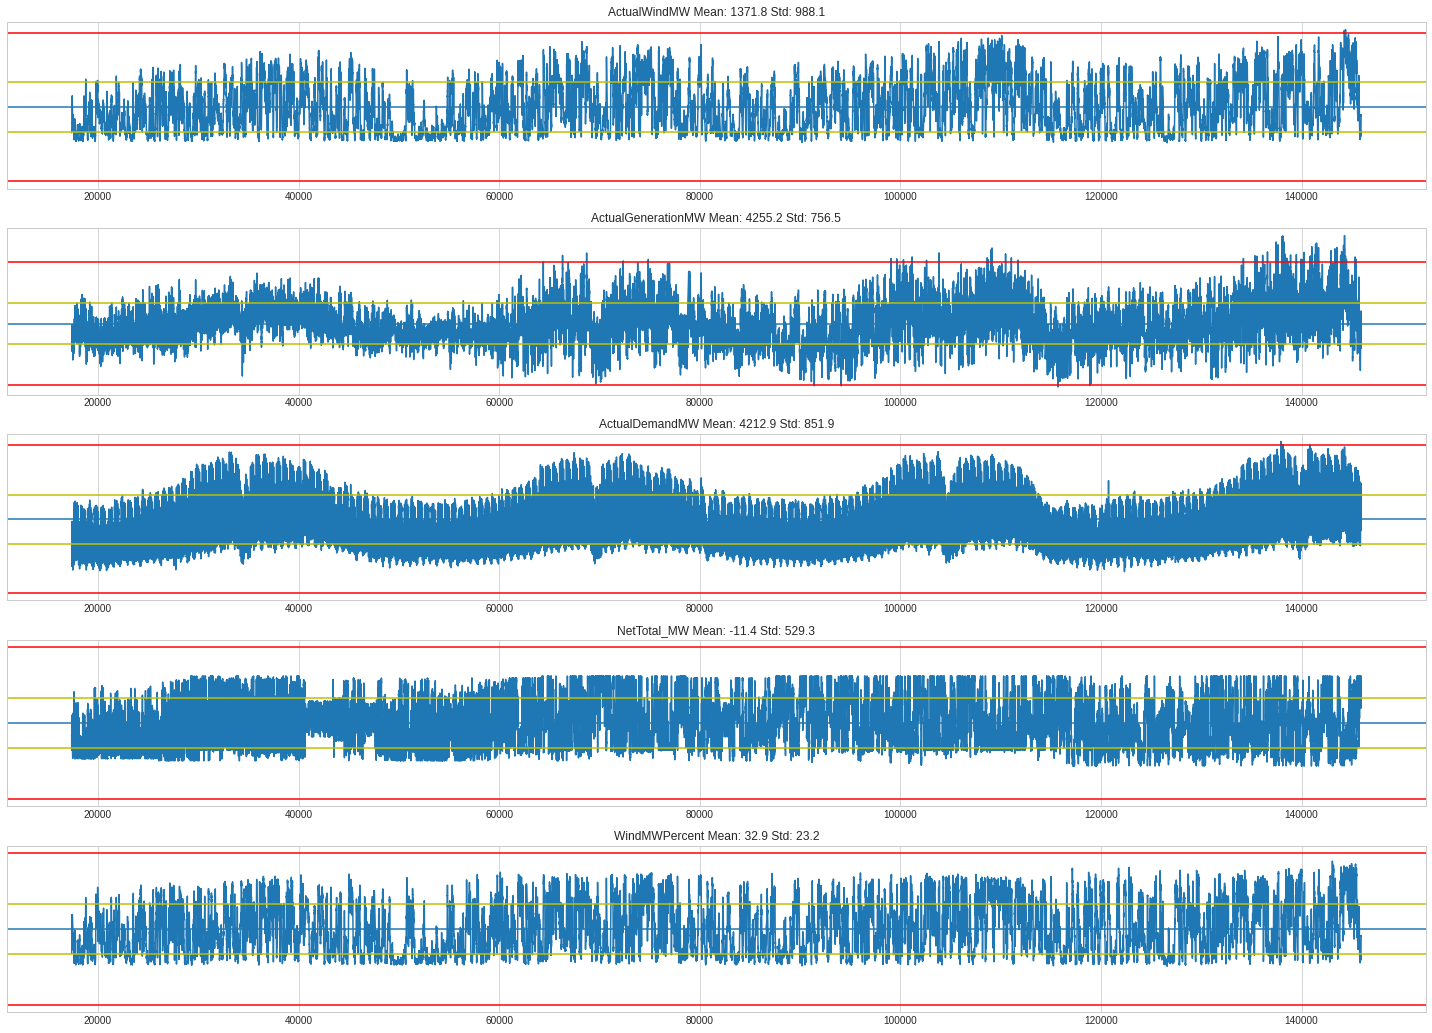

In [ ]:
plotOutliers(newdf, attributes)

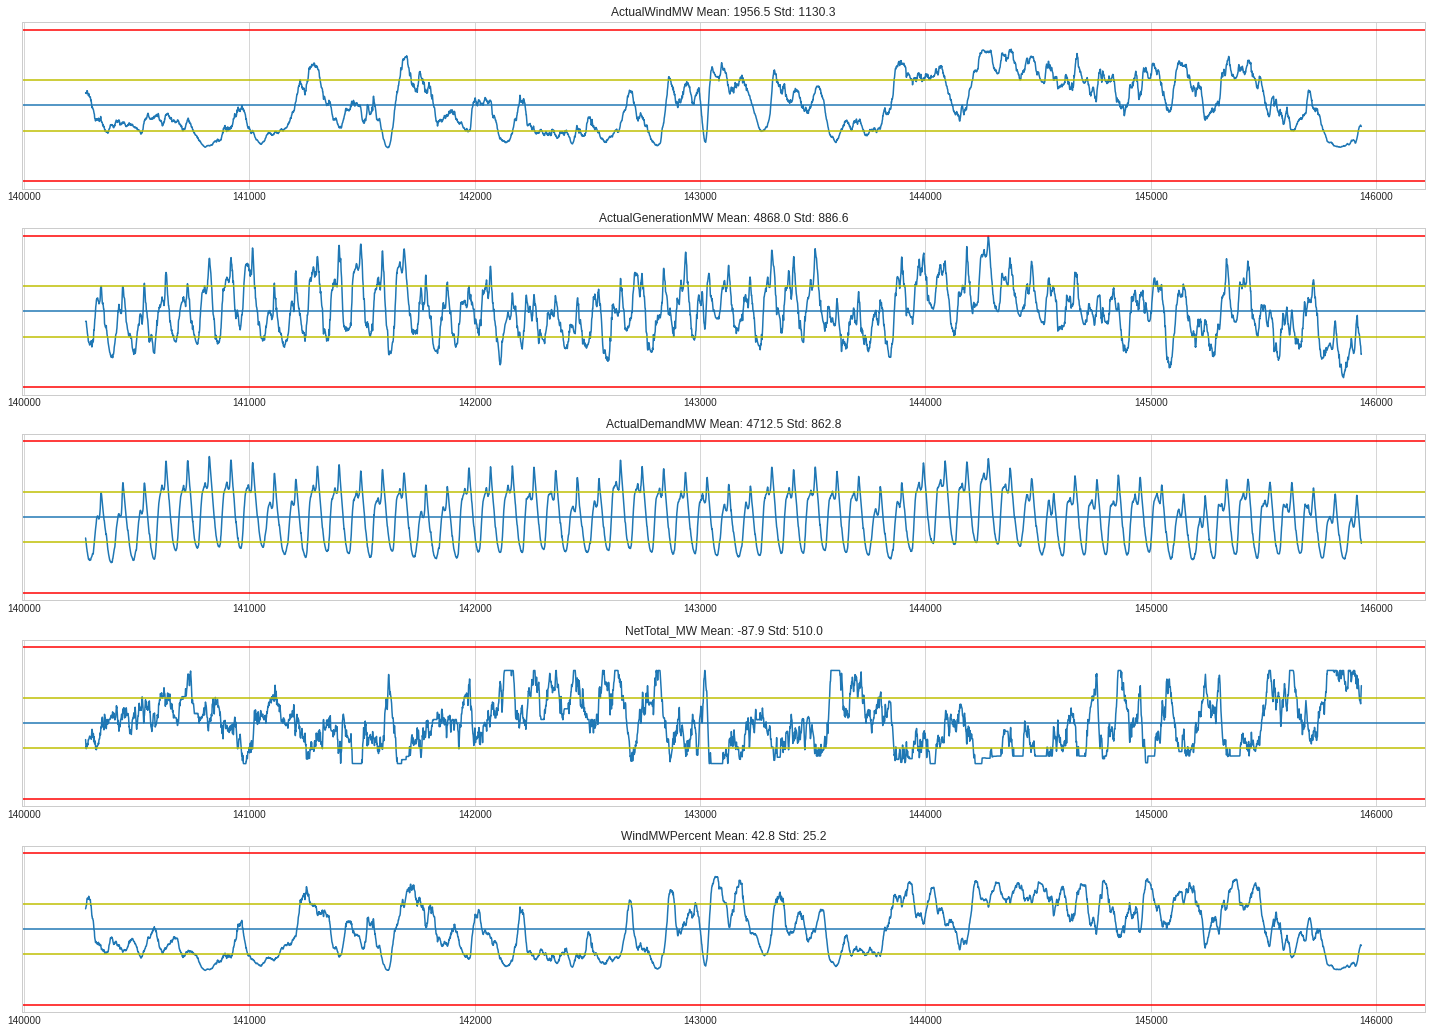

In [ ]:
plotOutliers(recentdf, attributes)

# Wind generation over 70% to date ("surplus" case when wind electricity is likely to be "curtailed" )

In [ ]:

newdf['ActualWindMW_smoothed'] = newdf['ActualWindMW'].rolling(window=4).mean()
newdf['ActualGenerationMW_smoothed'] = newdf['ActualGenerationMW'].rolling(window=4).mean()

In [ ]:
# Check smoothing by hour makes sense
redAtts = ['ActualWindMW',  'ActualWindMW_smoothed', 'ActualGenerationMW', 'ActualGenerationMW_smoothed']

recentdf = newdf.loc[(newdf['date'] > "2021-02-10 00:00:00") & (newdf['date'] < "2021-02-14 00:00:00") ]


fig = make_subplots(
    rows=len(redAtts), cols=1,
    subplot_titles=(redAtts ))
i =1 



fig.print_grid 
for col in redAtts:
  #fig = px.scatter(missingAW, x='date', y='hour')
  fig.add_trace(go.Scatter(x=recentdf.date, y=recentdf[col], name=(col),  hovertext='label'), i, 1, secondary_y=False)
  #fig.add_hline(y=eirgridCols[col]].mean()) 
  i = i+1

fig.update_layout(height=1000, width=1400)
fig.show()

### Smoothing: Resample hourly to match hourly weather forecast

In [ ]:
newdf.columns

Index(['Unnamed: 0', 'date', 'Year', 'Month', 'DayTime', ' REGION',
       'ActualDemandMW', ' FORECAST DEMAND(MW)', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'hour', 'isweekday', 'month',
       'NetTotal_MW', 'EWIC_MW', 'MOYLE_MW', 'year', 'WindMWPercent',
       'ActualWindMW_smoothed', 'ActualGenerationMW_smoothed'],
      dtype='object')

In [ ]:
# Resample by hour
hourly_df = newdf[['date', ' REGION',
       'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'NetTotal_MW']].resample('H', on='date').sum()

# Divide by 4 to get Hourly average power (MW)
hourly_df['ActualDemandMW'] = hourly_df['ActualDemandMW'] / 4
hourly_df['ForecastWndMW'] = hourly_df['ForecastWndMW'] / 4
hourly_df['ActualWindMW'] = hourly_df['ActualWindMW'] / 4
hourly_df['ActualGenerationMW'] = hourly_df['ActualGenerationMW'] / 4
hourly_df['NetTotal_MW'] = hourly_df['NetTotal_MW'] / 4

hourly_df['WindMWPercent'] = hourly_df['ActualWindMW'] / hourly_df['ActualDemandMW'] * 100

hourly_df = hourly_df.reset_index()
hourly_df["hour"] = 0
hourly_df["isweekday"] = False
hourly_df["month"] = 0
hourly_df["year"] = 0
hourly_df = hourly_df.apply(settimeatt, axis='columns')

hourly_df.tail()

,date,ActualDemandMW,ForecastWndMW,ActualWindMW,ActualGenerationMW,NetTotal_MW,WindMWPercent,hour,isweekday,month,year
32131,2021-02-28 19:00:00,5288.00,602.50,571.75,4562.25,721.50,10.812216,19,False,2,2021
32132,2021-02-28 20:00:00,4913.25,719.00,809.75,4219.75,682.00,16.480944,20,False,2,2021
32133,2021-02-28 21:00:00,4540.50,782.75,976.75,4059.25,466.25,21.511948,21,False,2,2021
32134,2021-02-28 22:00:00,4156.75,776.75,1039.25,3798.25,348.25,25.001504,22,False,2,2021
32135,2021-02-28 23:00:00,3907.50,776.00,1034.00,3466.50,503.25,26.461932,23,False,2,2021


In [ ]:
hourly_df.tail()

,date,ActualDemandMW,ForecastWndMW,ActualWindMW,ActualGenerationMW,NetTotal_MW,WindMWPercent,hour,isweekday,month,year
32131,2021-02-28 19:00:00,5288.00,602.50,571.75,4562.25,721.50,10.812216,19,False,2,2021
32132,2021-02-28 20:00:00,4913.25,719.00,809.75,4219.75,682.00,16.480944,20,False,2,2021
32133,2021-02-28 21:00:00,4540.50,782.75,976.75,4059.25,466.25,21.511948,21,False,2,2021
32134,2021-02-28 22:00:00,4156.75,776.75,1039.25,3798.25,348.25,25.001504,22,False,2,2021
32135,2021-02-28 23:00:00,3907.50,776.00,1034.00,3466.50,503.25,26.461932,23,False,2,2021


In [ ]:
# Hours when wind electricity was over 70% in total
hourly_df.loc[hourly_df['WindMWPercent'] > 70].shape[0] 

#mean 42.8 + Std: 25.2 : 68

2634

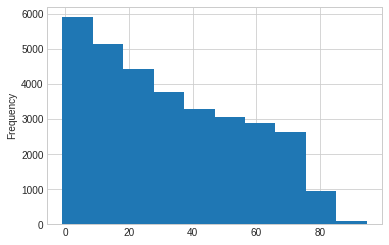

In [ ]:
hourly_df['WindMWPercent'].plot.hist()

In [ ]:
import plotly.express as px
fig = px.scatter(hourly_df, x='hour' ,y='WindMWPercent')
fig.show()


In [ ]:
fig = px.scatter(hourly_df, x='year' ,y='WindMWPercent')
fig.show()

In [ ]:
recentdf = hourly_df.loc[hourly_df['date'] > "2021-01-01 00:00:00" ]

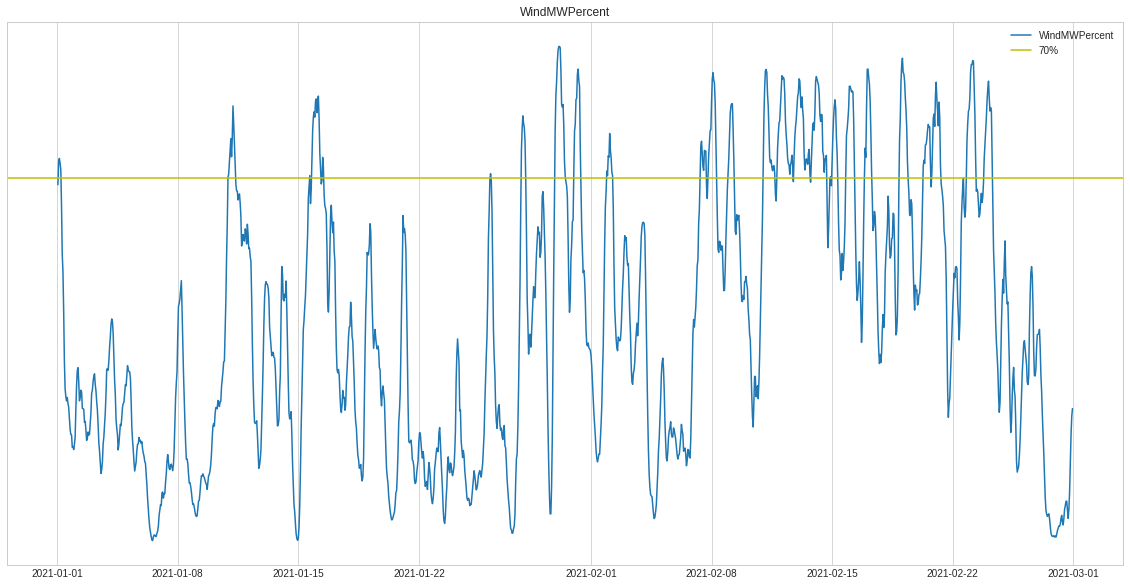

In [ ]:
fig = plt.figure(figsize=(20, 10))
# plt.subplot(14, 1, (i+1))
f = plt.gca()
f.axes.get_yaxis().set_visible(False)
f.axes.set_title("WindMWPercent")

x=recentdf.date
y=recentdf.WindMWPercent

plt.plot(x, y, label="WindMWPercent")
plt.axhline(y=70, color='y', label="70%")
plt.legend()

fig.show()

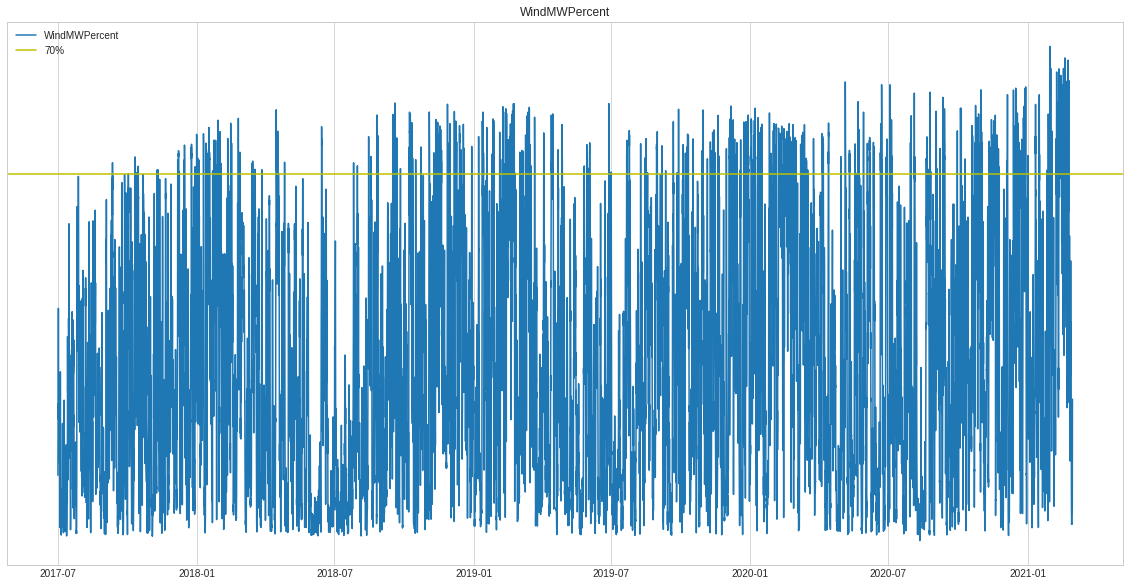

In [ ]:
fig = plt.figure(figsize=(20, 10))
# plt.subplot(14, 1, (i+1))
f = plt.gca()
f.axes.get_yaxis().set_visible(False)
f.axes.set_title("WindMWPercent")

x=hourly_df.date
y=hourly_df.WindMWPercent

plt.plot(x, y, label="WindMWPercent")
plt.axhline(y=70, color='y', label="70%")
plt.legend()

fig.show()

## Save Hourly Clean data

In [ ]:
fileP = 'IslandElectricityOnly2017_2020v3Clean.csv'
hourly_df.to_csv(fileP)

TODO:
- Wavelet / smoothing transform?
- 